###Loading the data from kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vivekchaurasia69","key":"663aeba89e7765c3cbfde4a9d04cd3ef"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c LANL-Earthquake-Prediction

100% 2.27G/2.27G [00:09<00:00, 248MB/s]
100% 2.27G/2.27G [00:09<00:00, 252MB/s]


Unzip the dataset

In [ ]:
!unzip /content/LANL-Earthquake-Prediction.zip

Importing the libraries

In [6]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis

In [7]:
from numpy import cov
from scipy.stats import pearsonr

In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

###Loading the dataset


In [ ]:
df =  pd.read_csv("train.csv")
df.head(7)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691


In [ ]:
df.shape

(629145480, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
 #   Column           Dtype  
---  ------           -----  
 0   acoustic_data    int64  
 1   time_to_failure  float64
dtypes: float64(1), int64(1)
memory usage: 9.4 GB


In [ ]:
df.isnull().sum()

acoustic_data      0
time_to_failure    0
dtype: int64

##Removing outliers

In [ ]:
dataframe = df[(df["acoustic_data"] >-2.0) & (df["acoustic_data"]<41.0)]

In [ ]:
dataframe.head(3)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691


In [ ]:
dataframe.shape

(593798480, 2)

In [ ]:
np.dtype(dataframe["acoustic_data"])

dtype('int64')

In [ ]:
c = cov(dataframe["acoustic_data"] , dataframe["time_to_failure"])
c

array([[14.15383512, -0.97560597],
       [-0.97560597, 18.78416789]])

In [ ]:
corr, _ = pearsonr(dataframe["acoustic_data"] , dataframe["time_to_failure"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.060


#Feature Engineering

Creating new features with rolling window ans statistics.

In [ ]:
#https://www.youtube.com/watch?v=T2mQiesnx8s
from scipy.stats import kurtosis , skew
def fn1(x):
    features = {}
    features['Mean'] = x.mean()
    features['Std'] = x.std()
    features['kurtosis']  = x.kurtosis()
    features['skew'] = x.skew()
    features['min'] = x.min()
    features['max'] = x.max()
    features['median'] = x.median()
    features["10th precentile"] = np.percentile(x, 10)
    features["50th precentile"] = np.percentile(x, 50)
    features["90th precentile"] = np.percentile(x, 90)

    for j in [10 , 80 , 300]:
      me = x.rolling(j).mean().dropna()
      features["1_Mean" + str(j)] = me.mean()
      features["1_Std" + str(j)] = me.std()
      features["1_kurtosis" + str(j)] = kurtosis(me)
      features["1_skew" + str(j)] = skew(me)
      features["1_min" + str(j)] = me.min()
      features["1_max" + str(j)] = me.max()
      features["1_median" + str(j)] = me.median()
      features["1_10th precentile"+ str(j)] = np.percentile(me, 10)
      features["1_50th precentile"+ str(j)] = np.percentile(me, 50)
      features["1_90th precentile"+ str(j)] = np.percentile(me, 90)

      st = x.rolling(j).std().dropna()
      features["2_Mean" + str(j)] = st.mean()
      features["2_Std" + str(j)] = st.std()
      features["2_kurtosis" + str(j)] = kurtosis(st)
      features["2_skew" + str(j)] = skew(st)
      features["2_min" + str(j)] = st.min()
      features["2_max" + str(j)] = st.max()
      features["2_median" + str(j)] = st.median()
      features["2_10th precentile"+ str(j)] = np.percentile(st, 10)
      features["2_50th precentile"+ str(j)] = np.percentile(st, 50)
      features["2_90th precentile"+ str(j)] = np.percentile(st, 90)


      skewness = x.rolling(j).skew().dropna()
      features["3_Mean" + str(j)] = skewness.mean()
      features["3_Std" + str(j)] = skewness.std()
      features["3_kurtosis" + str(j)] = kurtosis(skewness)
      features["3_skew" + str(j)] = skew(skewness)
      features["3_min" + str(j)] = skewness.min()
      features["3_max" + str(j)] = skewness.max()
      features["3_median" + str(j)] = skewness.median()
      features["3_10th precentile"+ str(j)] = np.percentile(skewness, 10)
      features["3_50th precentile"+ str(j)] = np.percentile(skewness, 50)
      features["3_90th precentile"+ str(j)] = np.percentile(skewness, 90)

    return features


In [ ]:
from tqdm import tqdm
feature = []
y = []
for i in tqdm(range(int(dataframe.shape[0]/15000))):
    
    x = dataframe.iloc[i*15000 :i*15000 + 15000]
    y.append(x["time_to_failure"].values[-1])
    
    
    feature.append(fn1(x["acoustic_data"]))
feat = pd.DataFrame(feature)

100%|██████████| 3958/3958 [01:39<00:00, 39.85it/s]


In [ ]:
feat["time_to_failure"] = y

In [ ]:
feat.shape

(3958, 101)

In [ ]:
feat.head(1)

,Mean,Std,kurtosis,skew,min,max,median,10th precentile,50th precentile,90th precentile,...,3_Std300,3_kurtosis300,3_skew300,3_min300,3_max300,3_median300,3_10th precentile300,3_50th precentile300,3_90th precentile300,time_to_failure
0,6.343733,5.163528,7.657047,2.078115,-1,40,6.0,1.0,6.0,12.0,...,0.342442,4.964135,1.854091,-0.187168,2.173869,0.328373,0.097572,0.328373,0.854695,1.4649


Removing the correlated features 

In [ ]:
lst = feat.columns

In [ ]:
for i in lst:
  if len(feat[i].unique()) == 1:
    delete_feat = i
  

In [ ]:
delete_feat

'min'

In [ ]:
del feat[delete_feat]

In [ ]:
lst = feat.columns
for i in range(0 , len(feat.columns)-1):
  corr, _ = pearsonr(feat[lst[i]] , feat[lst[i+1]])
  if float(corr) >= 0.5 or float(corr) <= -0.5:
    del feat[lst[i]]
    

In [ ]:
feat.shape

(3958, 34)

In [ ]:
feat.head(2)

,max,median,10th precentile,1_skew10,1_min10,2_Std10,2_skew10,2_min10,2_90th precentile10,3_Mean10,...,1_Std300,1_skew300,1_min300,2_Std300,2_skew300,2_min300,3_skew300,3_min300,3_max300,time_to_failure
0,40,6.0,1.0,2.580269,0.1,2.084186,2.577872,0.737865,5.808040,0.070303,...,2.307638,3.089599,4.820000,1.957180,2.092747,2.390699,1.854091,-0.187168,2.173869,1.464900
1,38,5.0,1.0,2.359710,0.7,1.340841,2.158732,0.674949,4.599517,0.069406,...,0.987192,2.407695,4.313333,1.167037,1.894042,2.331941,1.330438,-0.201372,1.424758,1.461696


Top 10 features of Feat

In [ ]:
x = feat.iloc[ :  , : -1]
y = feat.iloc[:  , -1 ]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.10)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [ ]:
reg = GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 9.5726


In [ ]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)

In [ ]:
lst = feat.columns

In [ ]:
sorted_idx

array([ 2,  0,  7, 16, 25,  1, 24, 23, 15,  5, 13, 32, 26, 11, 17, 31,  4,
       10, 14, 18, 28, 20, 12, 27, 22, 21, 30,  3, 19,  9,  6, 29,  8])

In [ ]:
list(sorted_idx)[-10:]

[27, 22, 21, 30, 3, 19, 9, 6, 29, 8]

In [ ]:
for i in list(sorted_idx)[-10:]:
  print(lst[i])
  print(" "*50)

2_Std300
                                                  
3_skew80
                                                  
2_min80
                                                  
3_skew300
                                                  
1_skew10
                                                  
2_Std80
                                                  
3_Mean10
                                                  
2_skew10
                                                  
2_min300
                                                  
2_90th precentile10
                                                  


In [ ]:
new_features = feat.iloc[: , sorted_idx[-10:]]
new_features.head(1)

,2_Std300,3_skew80,2_min80,3_skew300,1_skew10,2_Std80,3_Mean10,2_skew10,2_min300,2_90th precentile10
0,1.95718,0.84258,2.042236,1.854091,2.580269,1.939159,0.070303,2.577872,2.390699,5.80804


In [ ]:
new_features["time_to_failure"] = y.values 

In [ ]:
new_features.head(1)

,2_Std300,3_skew80,2_min80,3_skew300,1_skew10,2_Std80,3_Mean10,2_skew10,2_min300,2_90th precentile10,time_to_failure
0,1.95718,0.84258,2.042236,1.854091,2.580269,1.939159,0.070303,2.577872,2.390699,5.80804,1.4649


In [ ]:
new_features.to_csv('Lanl.csv')

#EDA on Top 10 features

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
new_features.isnull().sum()

2_Std300               0
3_skew80               0
2_min80                0
3_skew300              0
1_skew10               0
2_Std80                0
3_Mean10               0
2_skew10               0
2_min300               0
2_90th precentile10    0
time_to_failure        0
dtype: int64

#Distribution of all features

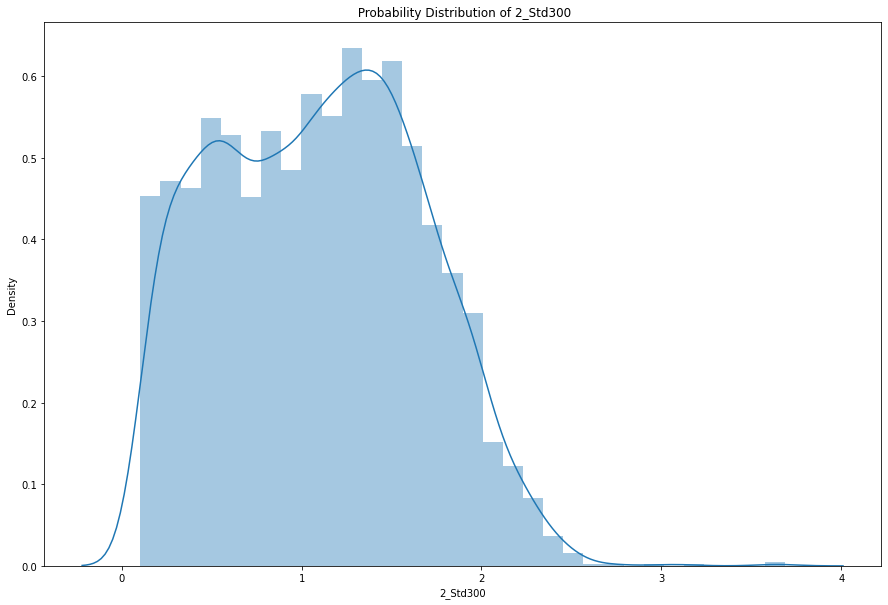

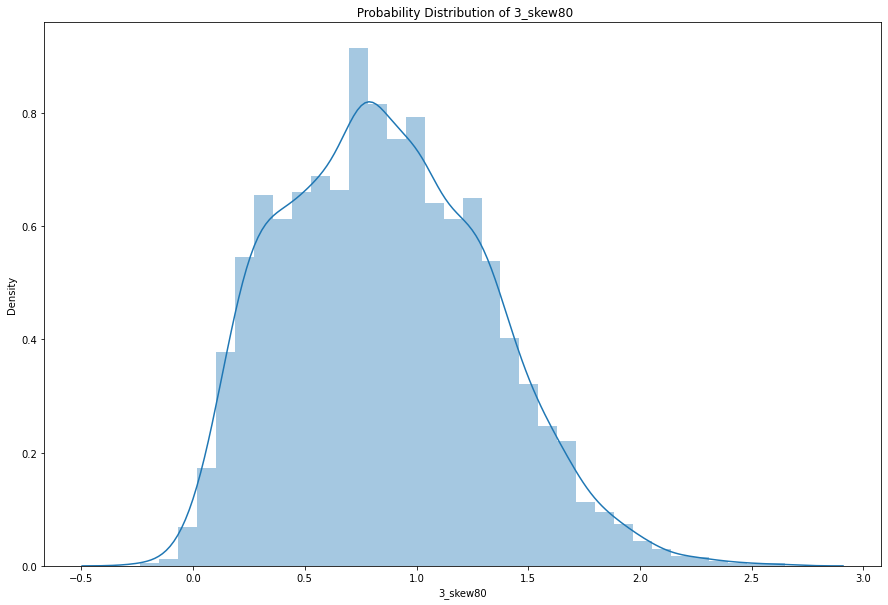

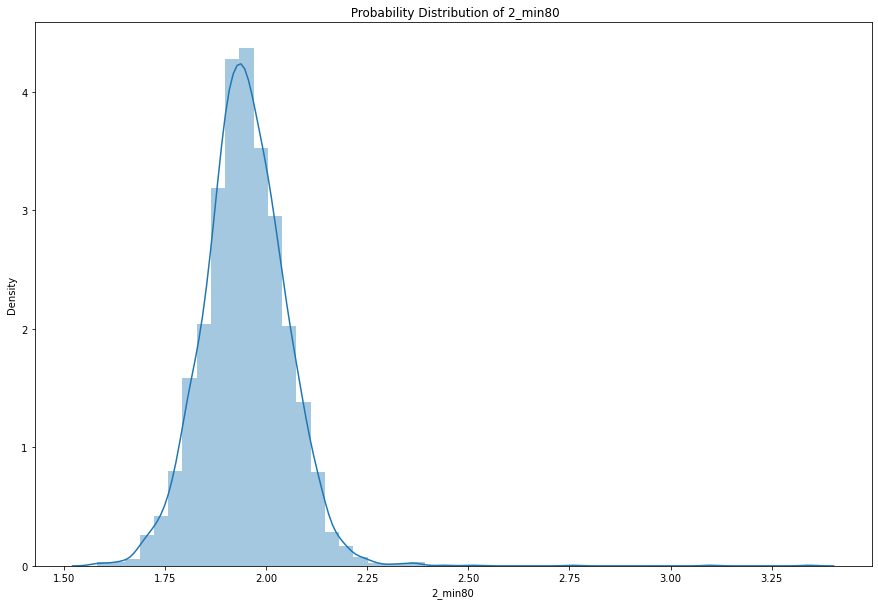

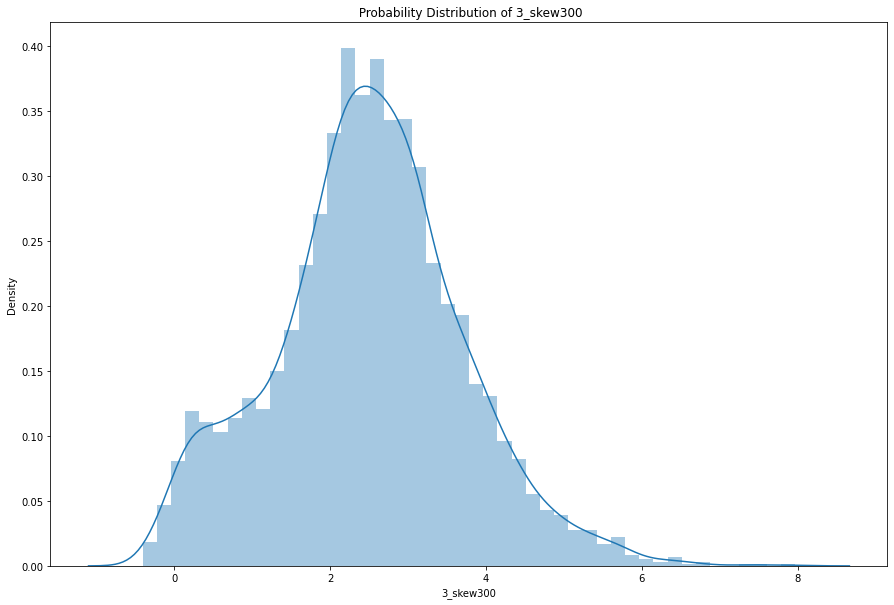

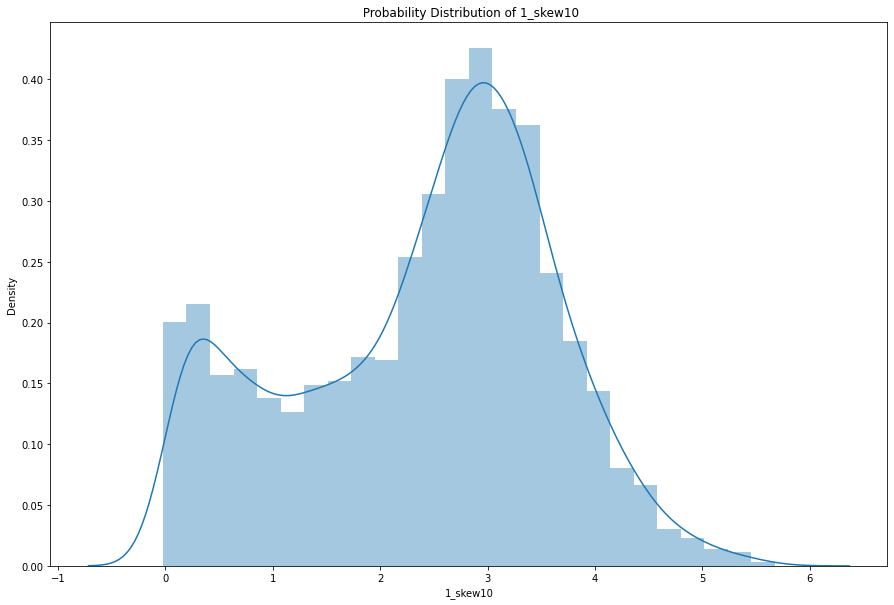

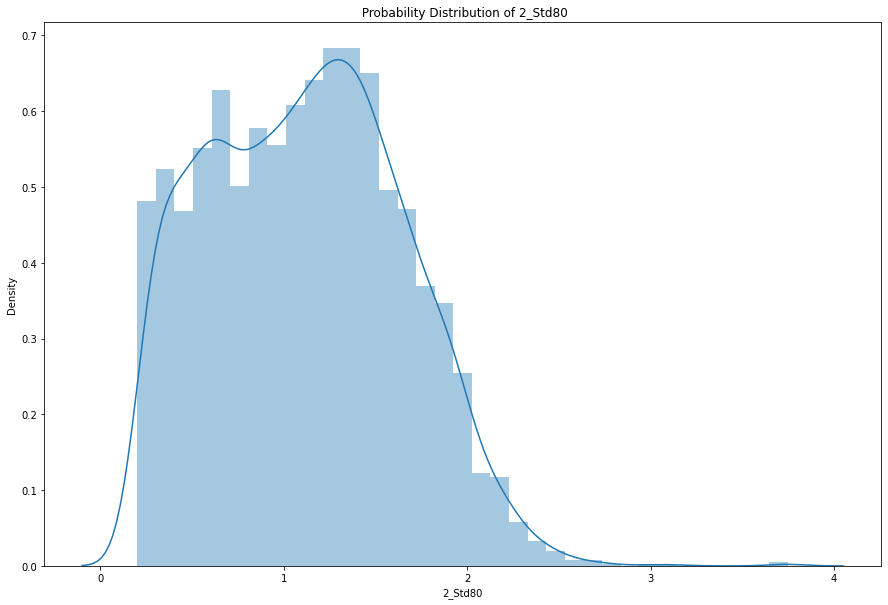

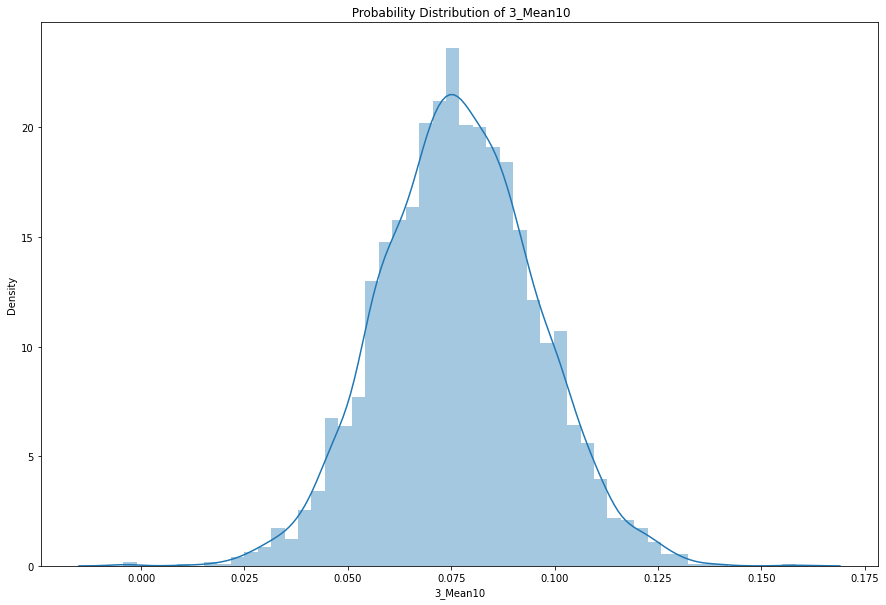

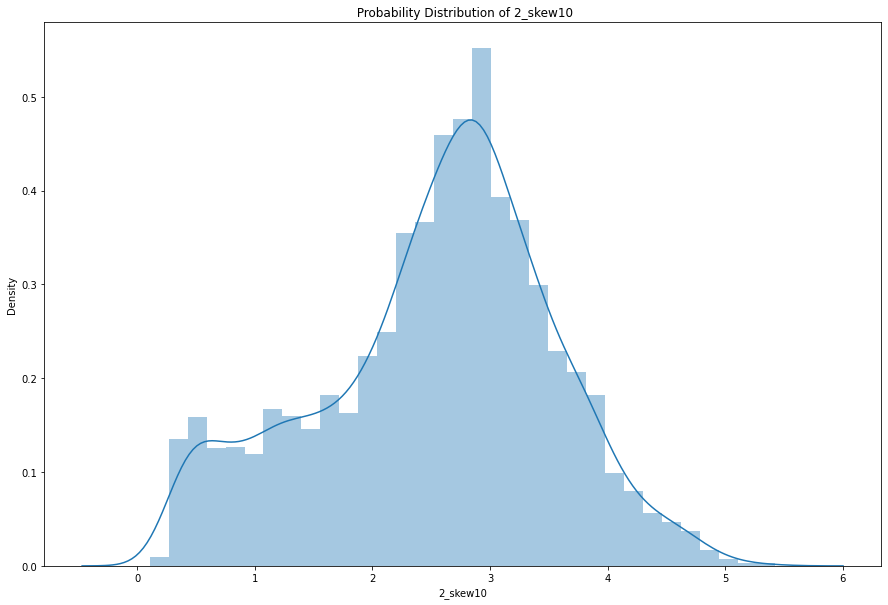

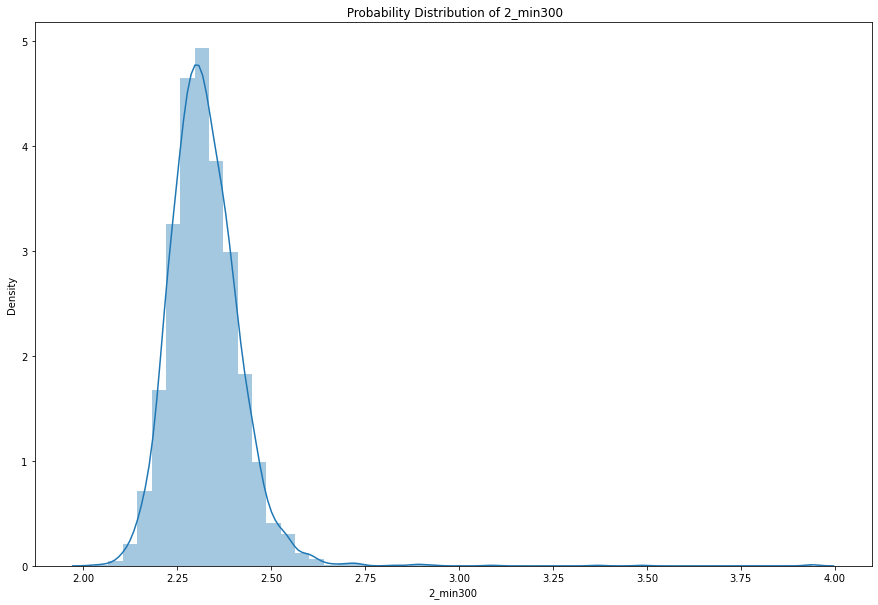

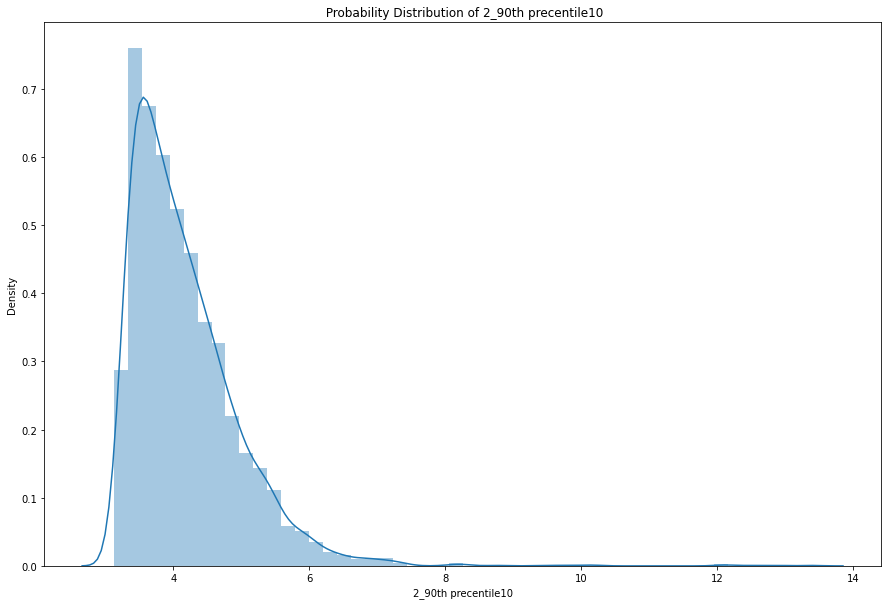

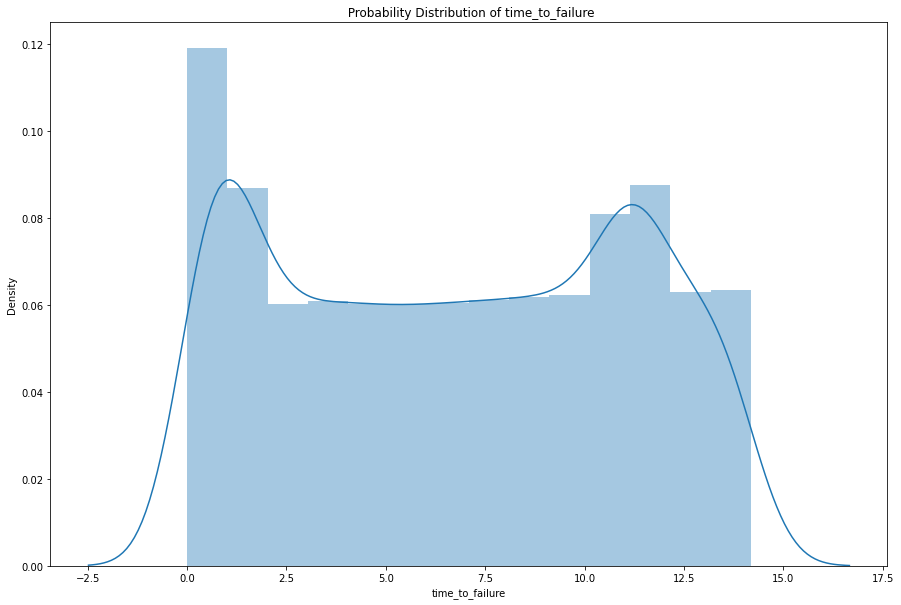

In [ ]:
for i in new_features.columns:
  plt.figure(figsize=(15,10))
  plt.title(" Probability Distribution of {}".format(i))
  sns.distplot(new_features[i])
  print(" "*100)

In [ ]:
new_features["time_to_failure"].min()

0.00079918902338

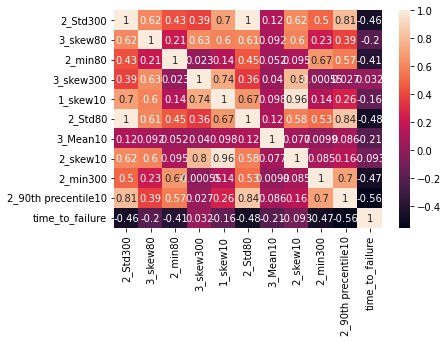

In [ ]:
correlation_mat = new_features.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

Here we can see that some features are correlated with each other but None of the features are correlating to time_to_failure feature which is a good thing

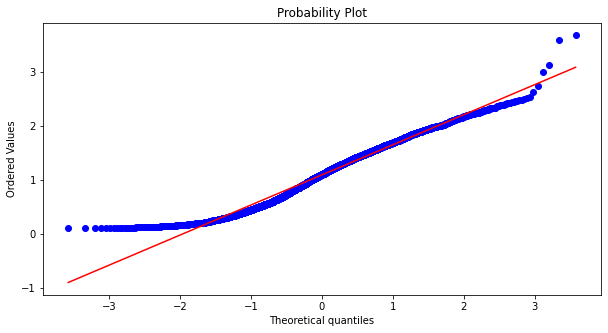

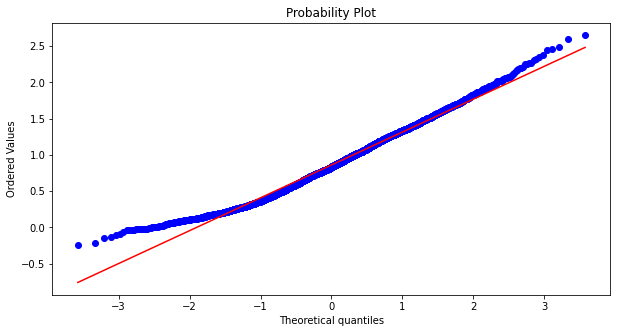

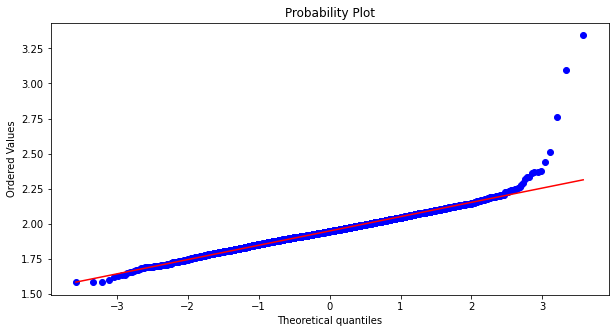

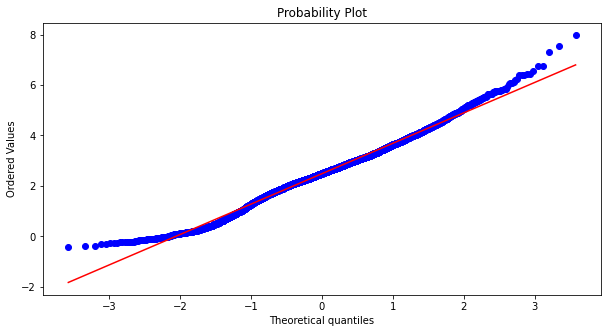

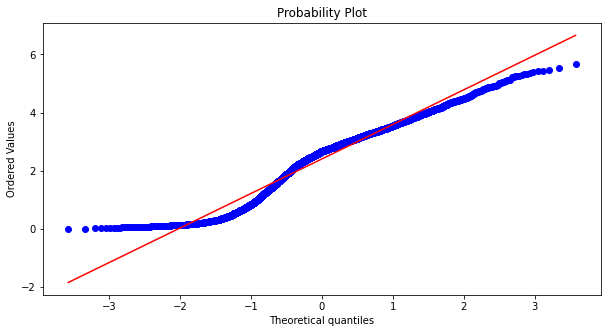

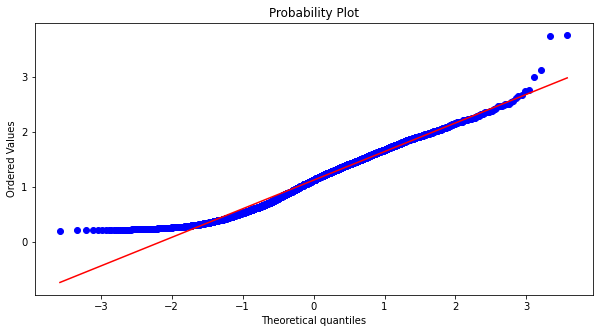

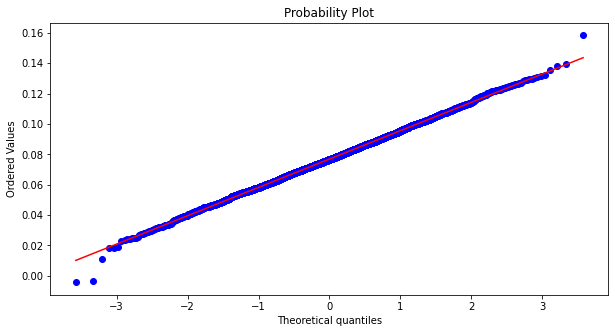

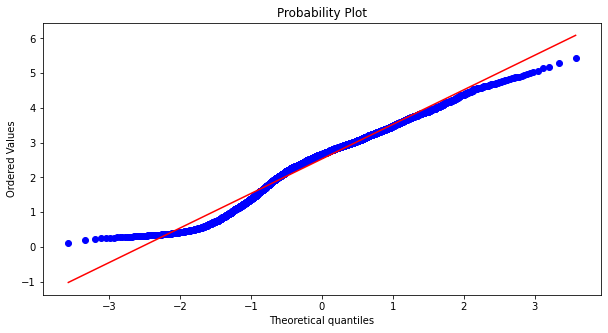

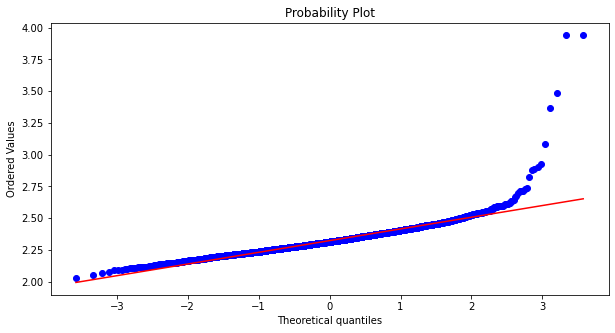

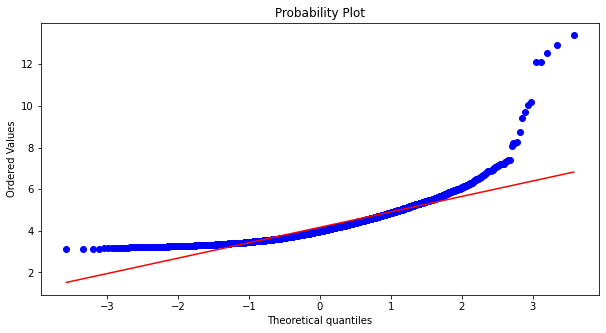

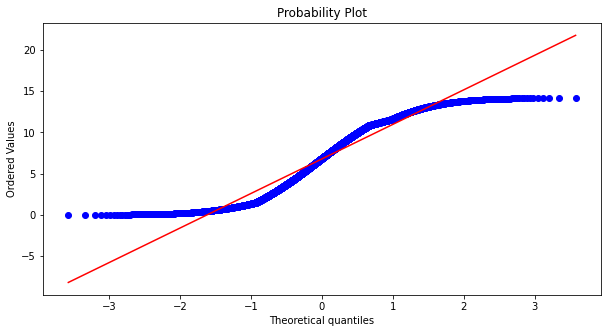

In [ ]:
from scipy import stats
import scipy

for i in new_features.columns:
  plt.figure(figsize=(10,5))

  scipy.stats.probplot(new_features[i], plot=plt)


#Box plot

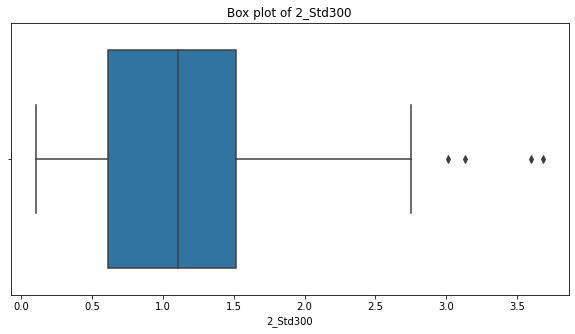

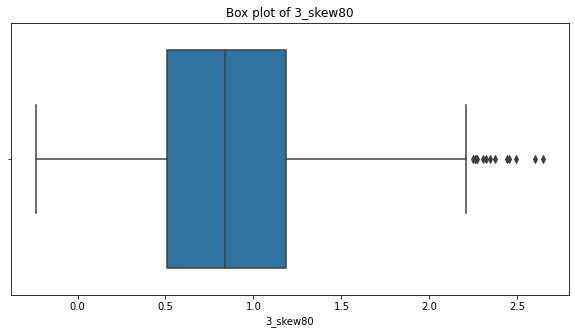

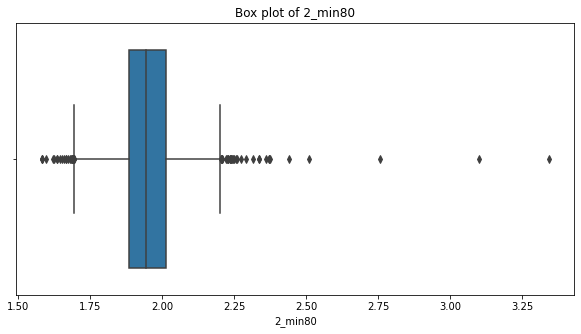

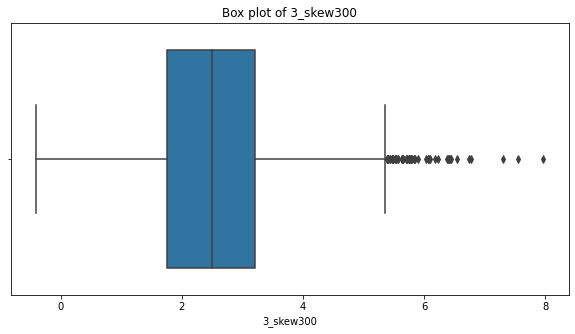

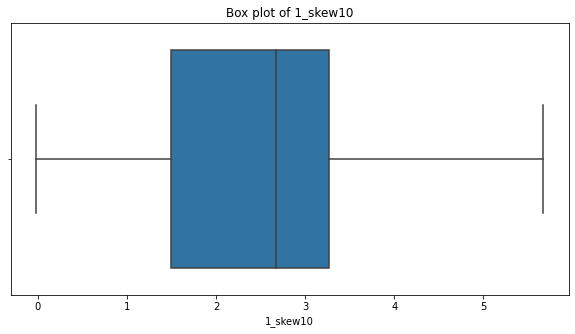

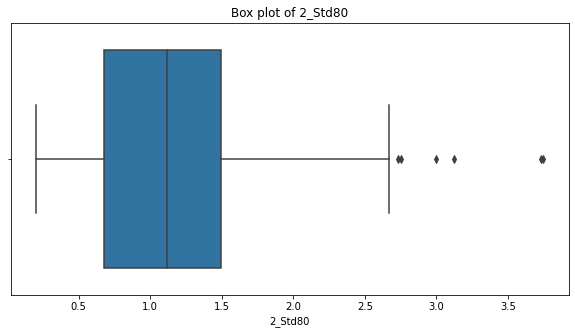

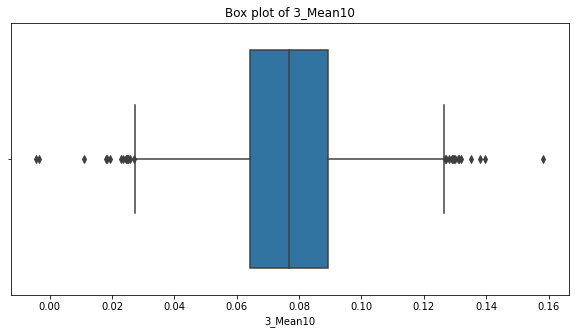

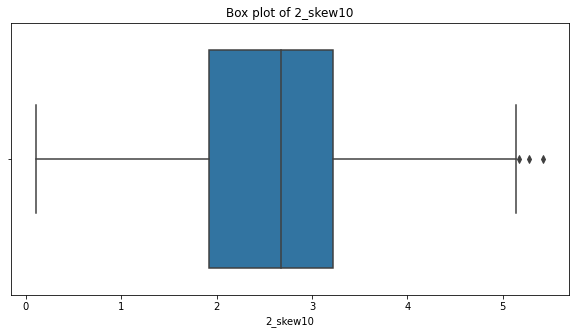

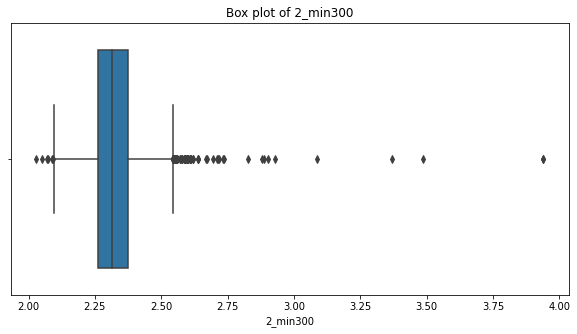

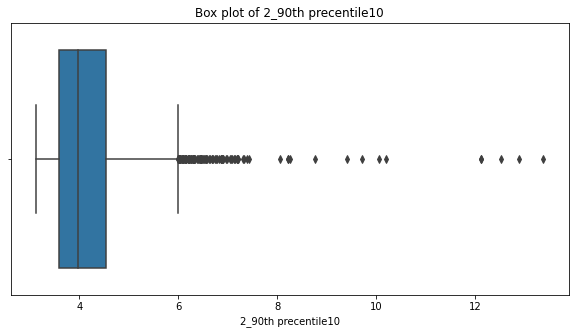

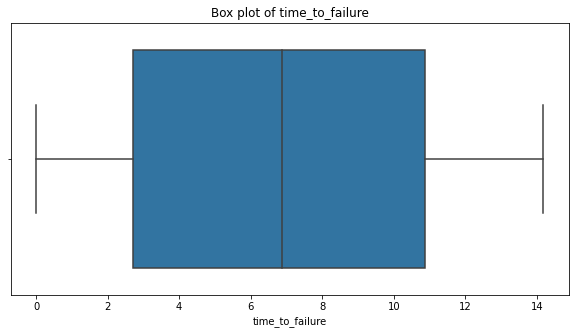

In [ ]:
for i in new_features.columns:
  plt.figure(figsize=(10,5))
  sns.boxplot(x = new_features[i]).set(title='Box plot of {}'.format(i))


There are few outliers present in the 2+90th_percentile10, 2_min300, 3_min10, 2_Std80, and 3_skew80

In [ ]:
new_features.columns

Index(['2_Std300', '3_skew80', '2_min80', '3_skew300', '1_skew10', '2_Std80',
       '3_Mean10', '2_skew10', '2_min300', '2_90th precentile10',
       'time_to_failure'],
      dtype='object')

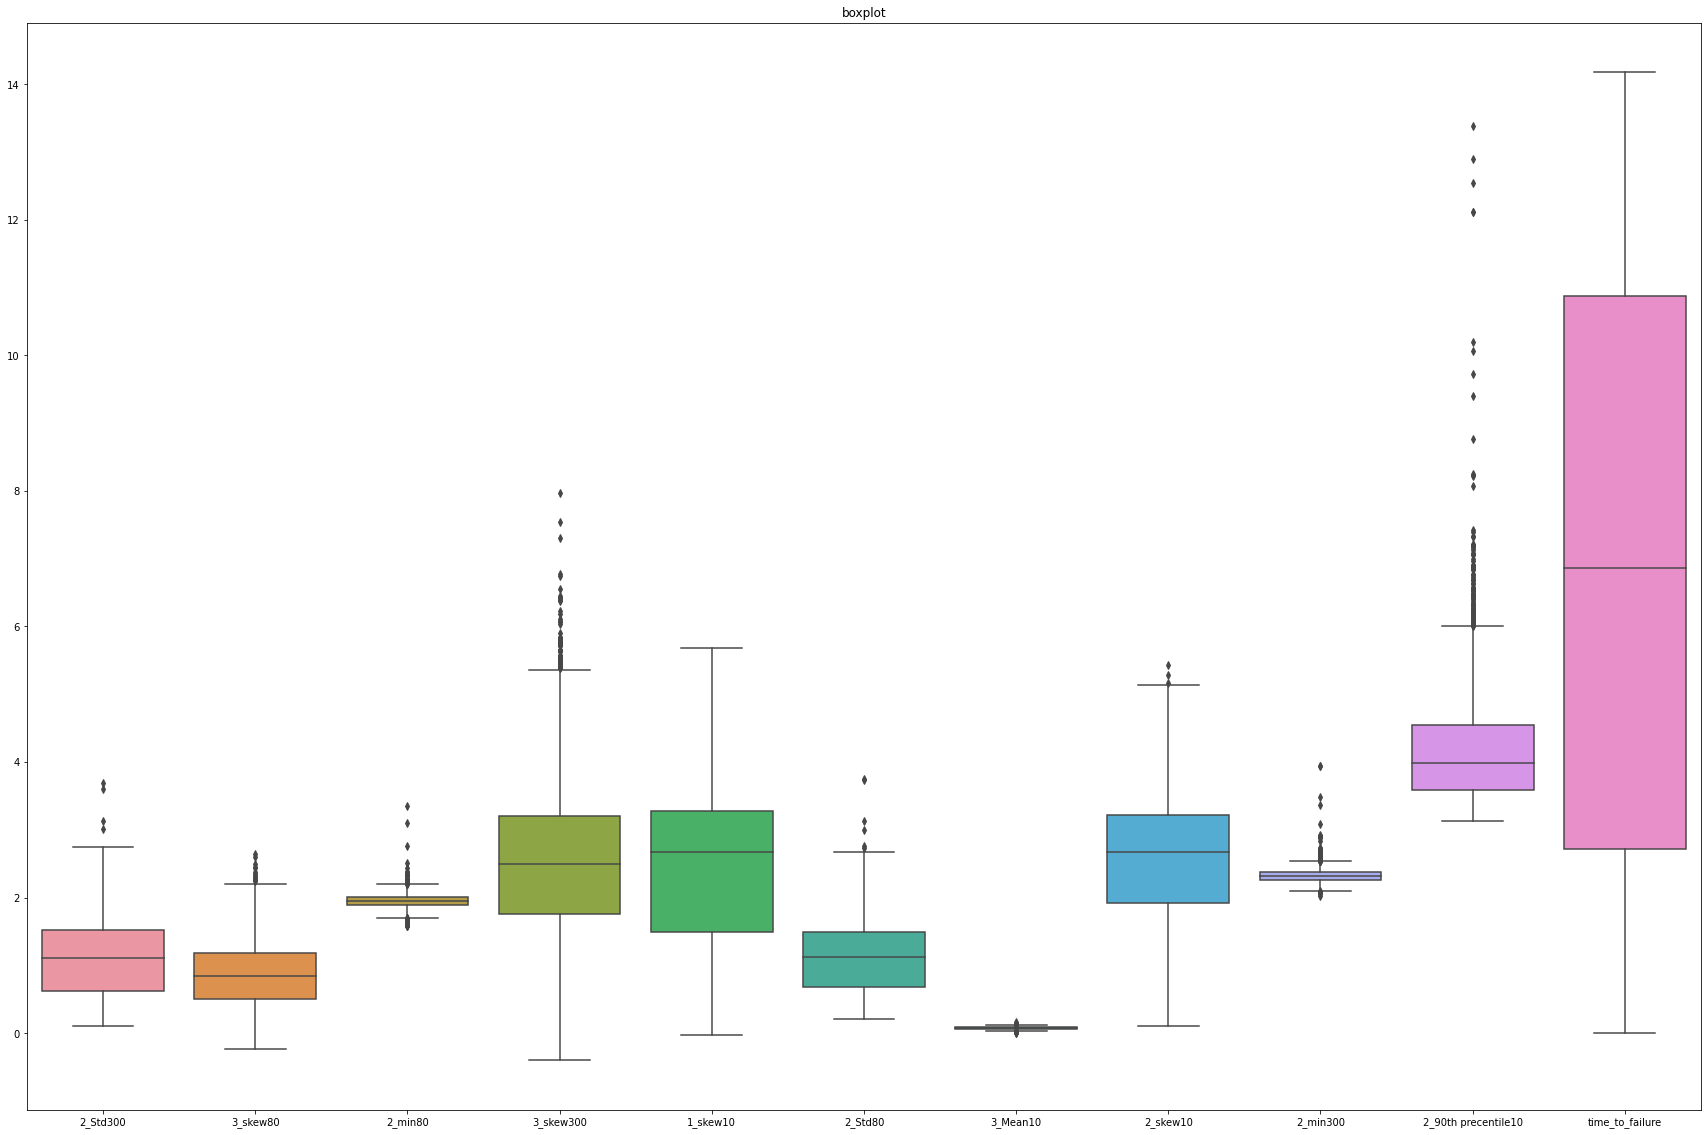

In [ ]:
plt.figure(figsize=(30 , 20))
ax = sns.boxplot(data = new_features)
plt.title("boxplot")
plt.show()